# Churn prediction for an energy company 🔌💡
## Part 3 - Model Building
### Importing packages and models

First, we import the necessary libraries and define key variables used throughout this notebook.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# SAS models
from sasviya.ml.linear_model import LogisticRegression as SASLogisticRegression
from sasviya.ml.tree import DecisionTreeClassifier as SASDecisionTreeClassifier
from sasviya.ml.tree import ForestClassifier as SASForestClassifier
from sasviya.ml.tree import GradientBoostingClassifier as SASGradientBoostingClassifier

# scikit-learn classes and models
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as SKGradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score

from model_building_utils import *

target = 'churn'
repo_path = '/workspaces/myfolder/energy-churn-prediction'

### Model Building for non-transformed dataset

In this section, we train and evaluate models using both the `scikit-learn` and `sasviya` libraries. The `sasviya` library is the new **SAS Python API** available in **SAS Viya Workbench**, allowing seamless integration of SAS analytics into Python workflows.

We start by comparing the performance of equivalent models from both libraries using 3-fold cross-validation. Then, we conduct a more thorough evaluation and model selection process using `Optuna` for hyperparameter tuning.

This analysis is performed on both the non-transformed and transformed datasets, which were prepared in the `Churn Prediction - Part 2` notebook. Here, we begin with the non-transformed dataset.

In [2]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data_no_tfm.csv")
merged_df.head(5)

,id,channel_sales,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,has_gas,imp_cons,margin_net_pow_ele,...,price_off_peak_var_std,price_peak_var_std,price_off_peak_fix_std,price_peak_fix_std,price_off_peak_var_max_diff,price_peak_var_max_diff,price_peak_fix_max_diff,product_modified,contract_age_at_last_modif,days_to_end
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,54946,0,0.00,0.0,1.78,Yes,0.00,25.44,...,0.007829,0.005126,1.050136,7.039226,0.028554,0.000568,0.097752,Yes,869,167
1,d29c2c54acc38ff3c0614d0a653813dd,Channel Missing,0,0,189.95,0.0,16.27,No,0.00,16.38,...,0.002212,0.024677,0.080404,0.000000,0.001567,0.085483,0.000000,No,0,243
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,0,0,47.96,0.0,38.72,No,0.00,28.60,...,0.002396,0.000506,0.087532,0.000000,0.000000,0.001281,0.000000,No,0,107
3,bba03439a292a1e166f80264c16191cb,Channel 2,0,0,240.04,0.0,19.83,No,0.00,30.22,...,0.002317,0.000000,0.080403,0.000000,0.000000,0.000000,0.000000,No,0,90
4,149d57cf92fc41cf94415803a877cb4b,Channel Missing,0,526,445.75,0.0,131.73,No,52.32,44.91,...,0.003847,0.001885,0.073681,0.044209,0.001969,0.001867,0.097749,No,0,67


Before training models, we split the dataset into training and test sets and generate lists of categorical and numerical columns.

In [3]:
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13148 (90.35 %)
- Number of rows with churn='Yes': 1405 (9.65 %)


One way to evaluate the quality of a probability estimate is by examining the ranking it produces. A good probability estimate should rank all the minority class observations (e.g., churners) and then those from the majority class (e.g., non-churners). In other words, it should assign high probabilities to positive examples and low probabilities to negative ones. A widely used ranking measure for imbalanced datasets is **AUC (Area Under the ROC Curve)**. If a threshold exists that perfectly separates churners from non-churners, the AUC will be 1.
Since our goal is to create a reliable **scoring list** for a retention campaign targeting potential churners, we prioritize ranking quality over overall predictive accuracy. Therefore, we will use AUC as the evaluation metric to select the best-performing model.
Finally, since our main objective is to assess how well the model ranks customers, we can compare models with different prior distributions without adjusting the posterior probabilities, as the bias due to undersampling does not affect the ranking order returned by the posterior probability.

For more information, check out [this article](https://www3.nd.edu/~dial/publications/dalpozzolo2015calibrating.pdf).

To get a quick comparison of the `scikit-learn` and `sasviya` models, we will evaluate their performance using **3-fold cross-validation** and without applying undersampling.

For this purpose, we will use the custom `train_and_evaluate_model` function, which constructs a pipeline for each model. This pipeline consists of three preprocessing steps before training the model:

- `MissingValueImputer`: Handles missing values in numeric columns by using a `sasviya` `DecisionTreeRegressor` to impute them.
- `DataScaler`: Standardizes numeric features to ensure consistent scaling. This step is included in the pipeline only if the `numeric_cols` parameter is provided with a list of numeric columns.
- `CategoricalLevelFilter`: Filters out rows with categorical values that were not observed in the training set, ensuring consistency in evaluation.

In addition, the `scikit-learn` models require a pre-processing step to properly encode categorical variables. This is not needed for `sasviya` models, as they automatically handle nominal columns by simply passing their names to the `nominals` parameter during training. For more details on how a nominal variable is evaluated by a SAS model, see [here](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbcasml/vwbcasml_forest_details04.htm), for example.

Then, the function computes the AUC scores for both the training and validation sets. Before calculating AUC, the validation set is filtered to remove rows with categorical values not present in the training set. This is managed through the `levels` attribute of the `CategoricalLevelFilter` transformer, which stores the distinct values of each categorical feature seen during training.

Since we are not applying undersampling for this comparison, the models will be trained on the full dataset without adjusting class distributions. This will serve as an initial performance benchmark before introducing random undersampling in the next section to assess their impact on model performance.

In [4]:
k = 3
metrics_list = []

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)
models = [
    (SASLogisticRegression(), "Logistic Regression", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor),('classifier', SKLogisticRegression(solver='liblinear'))]), "Logistic Regression", "scikit-learn"),
    (SASDecisionTreeClassifier(), "Decision Tree", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKDecisionTreeClassifier())]), "Decision Tree", "scikit-learn"),
    (SASForestClassifier(), "Random Forest", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKRandomForestClassifier())]), "Random Forest", "scikit-learn"),
    (SASGradientBoostingClassifier(), "Gradient Boosting", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKGradientBoostingClassifier())]), "Gradient Boosting", "scikit-learn")
]

for model, model_name, library in models:
    start_time = time.time()
    if library == 'SAS' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols, nominals=cat_cols)
    elif library == 'SAS' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, nominals=cat_cols)
    elif library == 'scikit-learn' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols)
    elif library == 'scikit-learn' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False)
    end_time = time.time()
    metrics["Runtime"] = end_time - start_time
    metrics_list.append(metrics)
    print(f"The {model_name} model from the {library} library has been trained.")
    print(f"Runtime: {end_time - start_time:.2f} s")
        
no_tfm_metrics_df = pd.concat(metrics_list, ignore_index=True)
no_tfm_metrics_df

The Logistic Regression model from the SAS library has been trained.
Runtime: 1.61 s
The Logistic Regression model from the scikit-learn library has been trained.
Runtime: 0.59 s
The Decision Tree model from the SAS library has been trained.
Runtime: 1.51 s
The Decision Tree model from the scikit-learn library has been trained.
Runtime: 0.65 s
The Random Forest model from the SAS library has been trained.
Runtime: 5.63 s
The Random Forest model from the scikit-learn library has been trained.
Runtime: 5.27 s
The Gradient Boosting model from the SAS library has been trained.
Runtime: 2.53 s
The Gradient Boosting model from the scikit-learn library has been trained.
Runtime: 8.58 s


,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std,Runtime
0,Logistic Regression,SAS,0.664,0.645,0.005,0.009,1.605195
1,Logistic Regression,scikit-learn,0.663,0.645,0.005,0.009,0.585327
2,Decision Tree,SAS,0.631,0.578,0.018,0.017,1.507118
3,Decision Tree,scikit-learn,1.000,0.563,0.000,0.011,0.646786
4,Random Forest,SAS,0.811,0.638,0.018,0.026,5.625817
5,Random Forest,scikit-learn,1.000,0.672,0.000,0.008,5.267790
6,Gradient Boosting,SAS,0.889,0.680,0.006,0.011,2.532613
7,Gradient Boosting,scikit-learn,0.814,0.685,0.008,0.010,8.581620


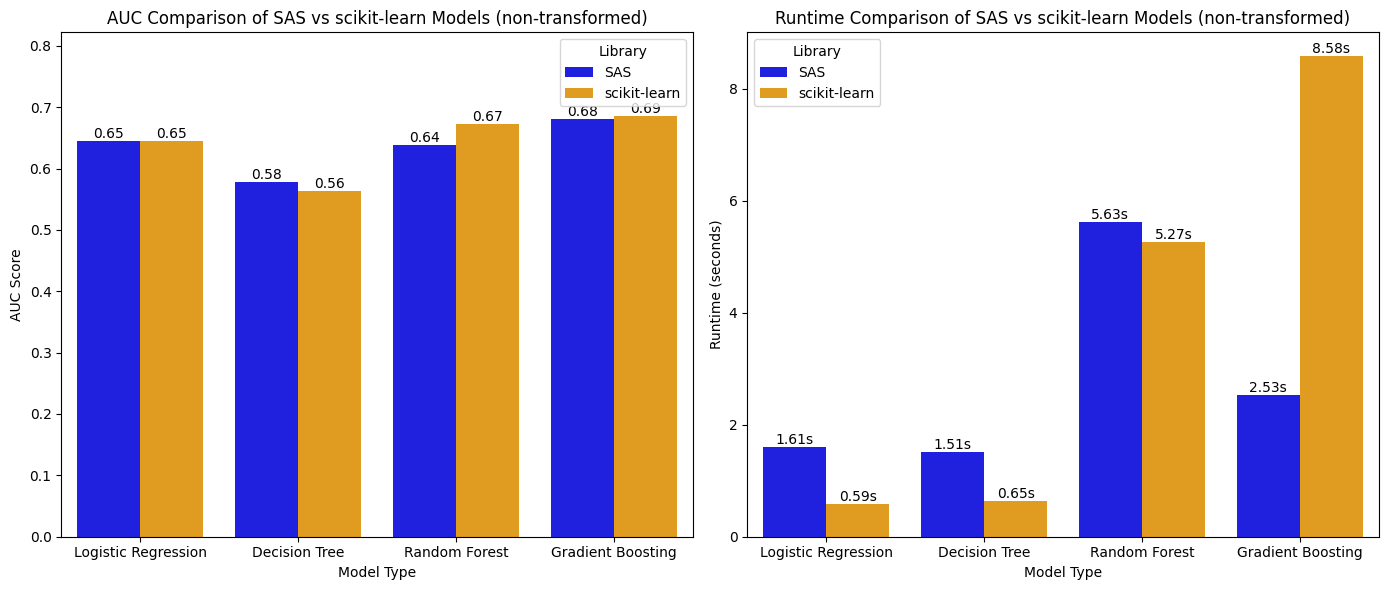

In [5]:
plot_auc_and_runtime(no_tfm_metrics_df, data_version='non-transformed')

The plots reveal that both libraries achieve similar AUC scores. However, there are notable differences in runtimes:

- **Logistic Regression** and **Decision Tree** models in `scikit-learn` run approximately twice as fast as their `sasviya` counterparts. **ADD LESS OVERFITTING FOR SAS DECISION TREE!**
- **Gradient Boosting** in `sasviya` is significantly more efficient, training 3.5 times faster than the `scikit-learn` version.

#### Hyperparameter Tuning and Model Selection

In this section, we perform hyperparameter tuning using the [Optuna](https://optuna.org/) library, an open-source tool for automated hyperparameter optimization. Optuna employs techniques like *Tree-structured Parzen Estimator (TPE)* to efficiently explore parameter space and select the best model. We consider both `scikit-learn` and `sasviya` implementations for the following classifiers:
- Random Forest
- Decision Tree
- Gradient Boosting

The hyperparameters are tuned based on the cross-validated AUC scores, ensuring the model's ability to generalize well to unseen data.

The code below demonstrates the following steps:
1. Creating an Optuna study to search for the best hyperparameters.
2. Retraining the model on the entire training set using the optimal hyperparameters.
3. Evaluating the best-performing model on both the training and test sets using AUC scores.

In [6]:
objective = Objective(X_train, y_train, preprocessor)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-12 14:24:11,271] A new study created in memory with name: no-name-7d604235-0509-40ab-b6bf-238d67d1552d
[I 2025-02-12 14:24:12,858] Trial 0 finished with value: 0.668805110594302 and parameters: {'classifier': 'rf', 'library': 'sklearn', 'resampling': False, 'rf_n_estimators': 63, 'rf_max_depth': 14, 'rf_min_samples_leaf': 28, 'rf_max_samples': 0.5305966517862303, 'rf_n_bins': 40, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.668805110594302.


In [7]:
best_parameters = study.best_params
print("Set of best parameters:")
print(best_parameters)

Set of best parameters:
{'classifier': 'rf', 'library': 'sklearn', 'resampling': False, 'rf_n_estimators': 63, 'rf_max_depth': 14, 'rf_min_samples_leaf': 28, 'rf_max_samples': 0.5305966517862303, 'rf_n_bins': 40, 'rf_class_weight': 'balanced'}


In [8]:
best_pipeline = train_best_pipeline(X_train, y_train, best_parameters, preprocessor)
cat_levels = best_pipeline.named_steps['cat_filter'].levels
valid_rows_mask_train = X_train[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
valid_rows_mask_test = X_test[list(cat_levels.keys())].apply(lambda col: col.isin(cat_levels[col.name])).all(axis=1)
y_train = y_train[valid_rows_mask_train]
y_test = y_test[valid_rows_mask_test]

auc_train, auc_test = compute_auc(best_pipeline, X_train, y_train, X_test, y_test)
print(f"- AUC score on the train set: {auc_train:.2f}")
print(f"- AUC score on the test set: {auc_test:.2f}")

- AUC score on the train set: 0.85
- AUC score on the test set: 0.69


### Model Building for transformed dataset

Now, we apply the same modeling approach to the transformed dataset. The preprocessing steps, which include encoding categorical features, are preserved, and the models are evaluated in the same way.

In [9]:
merged_df = pd.read_csv(f"{repo_path}/data/merged_data_tfm.csv")

In [10]:
X_train, X_test, y_train, y_test, cat_cols, cat_cols_with_two_values, cat_cols_with_more_values, numeric_cols = split_data_and_generate_column_lists(merged_df, target)

- Number of rows with churn='No': 13069 (90.32 %)
- Number of rows with churn='Yes': 1401 (9.68 %)


In [11]:
metrics_list = []

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', OrdinalEncoder(categories=[['No', 'Yes']]*len(cat_cols_with_two_values)), cat_cols_with_two_values),
        ('ohe', OneHotEncoder(dtype='int64', handle_unknown='ignore', sparse_output=False), cat_cols_with_more_values)
    ],
    remainder='passthrough',  # Keep the remaining columns as they are
    force_int_remainder_cols=False
)

models = [
    (SASLogisticRegression(), "Logistic Regression", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor),('classifier', SKLogisticRegression(solver='liblinear'))]), "Logistic Regression", "scikit-learn"),
    (SASDecisionTreeClassifier(), "Decision Tree", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKDecisionTreeClassifier())]), "Decision Tree", "scikit-learn"),
    (SASForestClassifier(), "Random Forest", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKRandomForestClassifier())]), "Random Forest", "scikit-learn"),
    (SASGradientBoostingClassifier(), "Gradient Boosting", "SAS"),
    (Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SKGradientBoostingClassifier())]), "Gradient Boosting", "scikit-learn")
]

for model, model_name, library in models:
    start_time = time.time()
    if library == 'SAS' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols, nominals=cat_cols)
    elif library == 'SAS' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, nominals=cat_cols)
    elif library == 'scikit-learn' and model_name == 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False, numeric_cols=numeric_cols)
    elif library == 'scikit-learn' and model_name != 'Logistic Regression':
        metrics = train_and_evaluate_model(X_train, y_train, model, model_name, library, k=k, resampling=False)
    end_time = time.time()
    metrics["Runtime"] = end_time - start_time
    metrics_list.append(metrics)
    print(f"The {model_name} model from the {library} library has been trained.")
    print(f"Runtime: {end_time - start_time:.2f} s")
        
tfm_metrics_df = pd.concat(metrics_list, ignore_index=True)
tfm_metrics_df

The Logistic Regression model from the SAS library has been trained.
Runtime: 72.02 s
The Logistic Regression model from the scikit-learn library has been trained.
Runtime: 67.52 s
The Decision Tree model from the SAS library has been trained.
Runtime: 71.89 s
The Decision Tree model from the scikit-learn library has been trained.
Runtime: 66.87 s
The Random Forest model from the SAS library has been trained.
Runtime: 77.11 s
The Random Forest model from the scikit-learn library has been trained.
Runtime: 74.26 s
The Gradient Boosting model from the SAS library has been trained.
Runtime: 75.49 s
The Gradient Boosting model from the scikit-learn library has been trained.
Runtime: 78.19 s


,Model Type,Library,AUC_train,AUC_val,AUC_train_std,AUC_val_std,Runtime
0,Logistic Regression,SAS,0.662,0.633,0.003,0.009,72.023245
1,Logistic Regression,scikit-learn,0.661,0.633,0.004,0.009,67.519408
2,Decision Tree,SAS,0.650,0.597,0.004,0.010,71.885925
3,Decision Tree,scikit-learn,1.000,0.558,0.000,0.006,66.867535
4,Random Forest,SAS,0.823,0.628,0.006,0.016,77.105775
5,Random Forest,scikit-learn,1.000,0.658,0.000,0.009,74.260631
6,Gradient Boosting,SAS,0.897,0.669,0.003,0.014,75.488371
7,Gradient Boosting,scikit-learn,0.808,0.684,0.005,0.006,78.188054


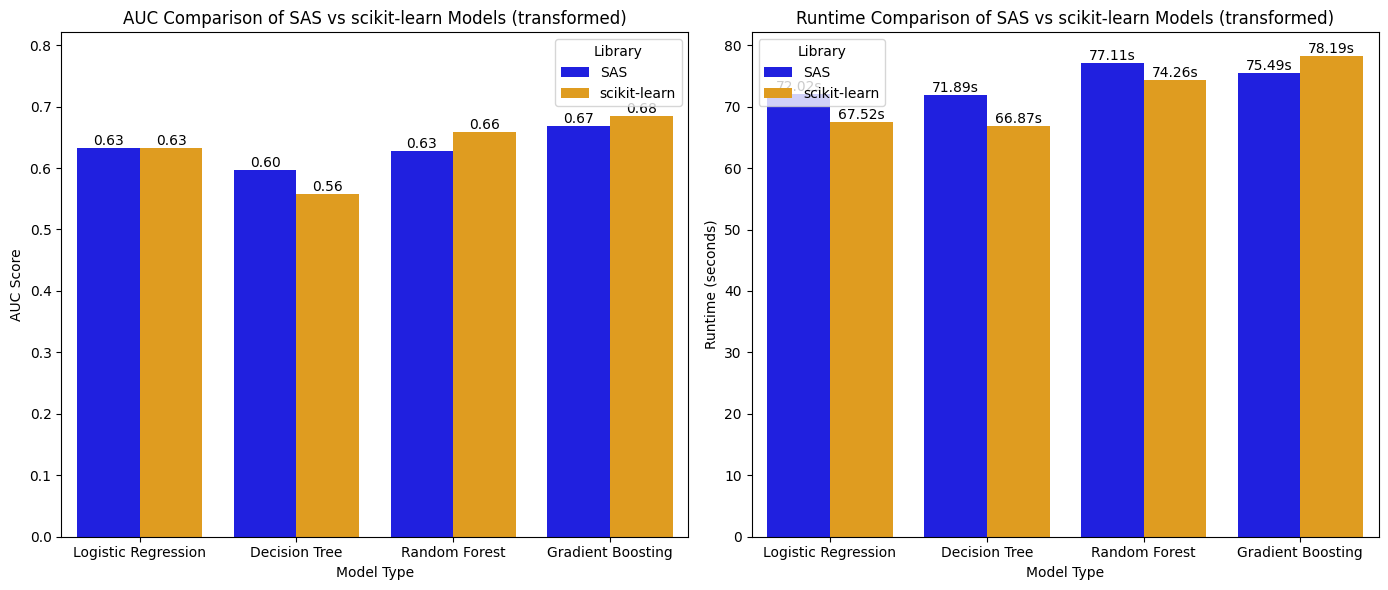

In [12]:
plot_auc_and_runtime(tfm_metrics_df, data_version='transformed')

The AUC improvement from the non-transformed dataset to the transformed dataset is marginal, indicating that the feature transformation did not significantly improve model performance. Given that the runtimes are also higher in this case (due to the missing value imputation of some engineered features, see Part 2) and interpretability would be more challenging, we decided to retain the model identified through the hyperparameter tuning procedure on the non-transformed dataset.

**Note**: Considering all the data transformations at once might not provide a complete understanding of which feature engineering tasks truly contribute to improving model performance and which do not. Therefore, it could be beneficial to experiment with one data transformation step at a time, or explore new transformations. However, this approach was not explored in this notebook.

### Cutoff optimization

The SAS Gradient Boosting model is the one performing better on test data (**CHECK if I really obtain this model!**). Therefore, this is the model we'll choose for identifying churners among our customer base to take action and try to keep them. 

Let's assume that to prevent a client from churning, PowerCo issues a 10% discount on their electricity price. We also assume that the efficiency of this discount is 80%, i.e. 80% of the targeted at-risk customers are persuaded to stay after receiving the discount.

Even though PowerCo doesn't want either to lose a client and is ready to give it a discount, they don't want to hand out free discounts and offer it also to customers who would stay anyway. Keeping that in mind, let's now identify the churn probability threshold that enables us to optimize the overall profit for PowerCo. The estimation of the optimal probability cutoff is performed using the test, in order to simulate how the model would behave on unseen data.

To this aim, we can compute for different probability thresholds the profit function as:
$$
\text{Profit}(p)=\text{Gains}-\text{Loss}+\text{Prevented Loss}-\text{Discount Loss}
$$
where:
- **Gains** represents the total potential profit if no customers churn, therefore this value assumes a perfect scenario where all customers are retained. The profit represents the average annual profit and has been calculated using the `margin_net_pow_ele` variable, which denotes the net margin on power subscriptions. This margin is assumed to refer to the average monthly margin and was therefore multiplied by 12 to derive the annual value.
- **Loss** represents the total profit lost due to customers who churned. This value accounts for the revenue lost because these customers are no longer contributing profit.

For each scenario, the retention campaign targets all customers with a predicted churn likelihood exceeding the probability threshold, $p$. 
- **Prevented Loss** is the profit gained from customers who were predicted to churn and actually churned, but would've been retained due to the campaign. This is scaled by the discount efficiency.
$$
\text{Prevented Loss}=\text{Sum of profits from targeted churners}\times\text{Discount Efficiency}
$$
- **Discount Loss** represents the total cost of offering discounts to targeted high-risk customers, broken down as follows:
    - **For non-churners**: The profit from customers who were predicted to churn but did not actually churn, multiplied by the discount rate, as they would've been targeted by the campaign.
        $$
        \text{Discount Loss (Non-Churners)} = \text{Sum of profits from targeted non-churners}\times\text{Discount Rate}
        $$
    - **For Churners**: The prevented loss scaled by the discount rate.
        $$
        \text{Discount Loss (Churners)} = \text{Prevented Loss}\times\text{Discount Rate}
        $$
    The total discount loss is the sum of these two components:
    $$
    \text{Discount Loss} = \text{Discount Loss (Non-Churners)} + \text{Discount Loss (Churners)}
    $$
    **Note**: In our example, we might assume that the discount is operated on the net margin (`margin_net_pow_ele` variable, which is only a component of the total tariff), to make computations easier, but it should be actually properly defined what a 10% tariff discount means.

Then, choose the threshold $p^*$ leading to the highest profit, given by $Profit(p^*)$.
We can compare this situation with what would’ve happened if we didn’t do anything:
$$
\text{Profit}=\text{Gains}-\text{Loss}
$$
to compute the financial impact of our model (percent improvement in profit). This value represents the baseline scenario in which no effort is made to prevent churn, and the business simply absorbs the loss from churned customers.

A <u>lower</u> probability threshold expands the retention campaign to more customers, leading to a higher `Discount Loss`.<br>Conversely, a <u>higher</u> probability threshold excludes some potential churners from the discount offer, increasing the risk of losing them and, therefore, decreasing the `Prevented Loss` term.

Optimal threshold: 0.2563
At this threshold, apply a 10.0% discount to identified high-risk customers.
Estimated financial impact: 26952.77 € (3.63% increase in profit compared to no intervention).
658 out of 2890 customers (22.77%) would receive the discount.


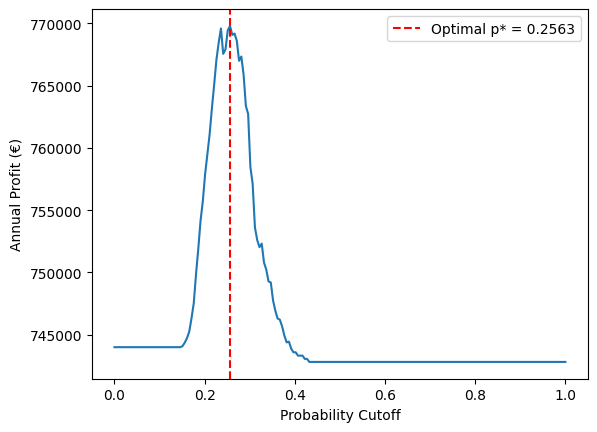

In [27]:
# y_pred_proba = best_pipeline.predict_proba(X_test).iloc[:,1]
y_pred_proba = best_pipeline.predict_proba(X_test)[:,1]
optimize_discount_strategy(y_test, y_pred_proba, margins, discount_rate=0.1, discount_efficiency=0.8)

### Next Steps

- Both when predicting a customer's churn likelihood and when determining the discount to offer a potential churner, considering **competitor tariffs** could be valuable. 
This can be achieved by introducing a new variable, such as `competitor_avg_tariff_lastmonth`, which represents the average tariff for the last month of the historical data period. This value can be calculated using data from sources like CHECK24, taking into account the *postal code* and the *number of kilowatt-hours consumed* (based on actual or estimated readings). These two inputs are essential for CHECK24's tariff comparisons, helping users identify the most competitive offers.<br>The discount is an hyperparameter of the model, in a sense, that can be tuned based on how much increase in profit you want to achieve and/or on the average current competitor price for the customer we are considering. For example, based on postal code and number of kWh consumed, the average competitor price can change, and then considering the percent difference between PowerCo tariff and average tariff can help us choose the discount needed in order for it to be effective.
- An additional step that could enhance the analysis is performing **customer segmentation** prior to training the churn model. By using clustering techniques, we could train separate churn models for each customer segment, allowing us to better understand the distinct patterns within different types of customers. This approach was not implemented in this project due to the limited data available for training, but it could provide valuable insights and improve the model's performance in the future.
- As mentioned earlier, it could be valuable to experiment with **one data transformation step at a time**, rather than considering all transformations at once. This would allow for a better understanding of which feature engineering tasks genuinely contribute to improving model performance. Additionally, exploring new transformations could lead to further enhancements.

### Conclusions

To wrap up, this project focused on churn prediction for an energy company using data from the `'client_data_raw.csv'` and `'price_data_raw.csv'` files. The workflow was divided into three main parts:

- **Data Quality and Preprocessing** (`'Churn Prediction - Part 1'`):
    - We began by inspecting variable types and conducting data quality checks.
    - Inconsistent rows were identified, removed, and saved to CSV files for further investigation with the data provider.
- **Feature Engineering and Data Transformation** (`'Churn Prediction - Part 2'`):
    - We imputed missing values in price trends, summarized price data for each customer ID, merged the datasets, and saved a non-transformed version of the table.
    - Several feature engineering and data transformation steps were applied to prepare the data for modeling, resulting in a transformed version of the table.
- **Model Building and Evaluation** (`'Churn Prediction - Part 3'`):
    - We trained and compared multiple machine learning models using both `scikit-learn` and SAS via the **Python API in SAS Viya Workbench**.
    - Model selection was performed using `Optuna` for hyperparameter tuning, and model performance was evaluated using cross-validated AUC scores.
    - After selecting the best-performing model, we retrained it on the entire training set.
    - We determined the optimal probability cutoff to maximize company profit, simulating a retention campaign where discounts were offered to customers predicted as likely churners. The cutoff optimization was tailored based on assumed retention efficiency and discount rates.

By following this structured approach, we provided a comprehensive framework for churn prediction, enabling the energy company to enhance its retention strategies, minimize customer loss, and maximize its profit effectively.